In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

# Convnet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x): return self.func(x)
    
def flatten(x): return x.view(x.shape[0], -1)

bs x 784 and puts it back as a a batch of images of 28 x 28

In [9]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
    Lambda(mnist_resize),
    nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), #14
    nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), #7
    nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(flatten),
    nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train : [1.78731, tensor(0.4053)]
valid : [0.57248193359375, tensor(0.8206)]
CPU times: user 5.17 s, sys: 1.79 s, total: 6.96 s
Wall time: 2.34 s


# CUDA

In [15]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 6GB'

In [16]:
torch.cuda.is_available()

True

In [17]:
#Somewhat more flexible way
device = torch.device('cuda', 0)

In [18]:
class CudaCallback(Callback):
    # initiate device
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [19]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [20]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [21]:
cbfs.append(CudaCallback)

In [22]:
model = get_cnn_model(data)

In [23]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [24]:
%time run.fit(3, learn)

train : [2.005243125, tensor(0.2900, device='cuda:0')]
valid : [0.721912548828125, tensor(0.7815, device='cuda:0')]
train : [0.41581546875, tensor(0.8716, device='cuda:0')]
valid : [0.2332434814453125, tensor(0.9295, device='cuda:0')]
train : [0.19592365234375, tensor(0.9410, device='cuda:0')]
valid : [0.2319900390625, tensor(0.9283, device='cuda:0')]
CPU times: user 4.73 s, sys: 956 ms, total: 5.68 s
Wall time: 5.71 s


# Refactor model

regroup all the conv/ relu in a single function

In [25]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
    nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU()
    )

In [26]:
#export
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    # transform    
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    # feed in size
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [27]:
mnist_view = view_tfm(1, 28, 28)

In [28]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [29]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7fba7b5b4ea0>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7fba30d55400>)]

with adaptive avg pool, can now work on any size input

In [30]:
nfs = [8, 16, 32, 32]

In [31]:
def get_cnn_layers(data, nfs):
    # [1, 8, 16, 32, 32]
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==1 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [32]:
get_cnn_layers(data, nfs)

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), AdaptiveAvgPool2d(output_size=1), Lambda(), Linear(in_features=32, out_features=10, bias=True)]

In [33]:
type(get_cnn_layers(data, nfs))

list

In [34]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func= F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [35]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [36]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [37]:
run.fit(3, learn)

train : [1.742043125, tensor(0.3970, device='cuda:0')]
valid : [0.680131884765625, tensor(0.7941, device='cuda:0')]
train : [0.3401976953125, tensor(0.8964, device='cuda:0')]
valid : [0.1903227294921875, tensor(0.9440, device='cuda:0')]
train : [0.18899296875, tensor(0.9436, device='cuda:0')]
valid : [0.13424600830078126, tensor(0.9605, device='cuda:0')]


# Hooks

manual insertion

mean and standard deviation of each activations

In [38]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        # original
        for i, l in enumerate(self.layers):
            x = l(x)
        #original end
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    # when iter, return layer
    def __iter__(self): return iter(self.layers)    

In [39]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [40]:
run.fit(2, learn)

train : [2.326235, tensor(0.1346, device='cuda:0')]
valid : [2.30182265625, tensor(0.1064, device='cuda:0')]
train : [2.301528125, tensor(0.1135, device='cuda:0')]
valid : [2.3023662109375, tensor(0.1064, device='cuda:0')]


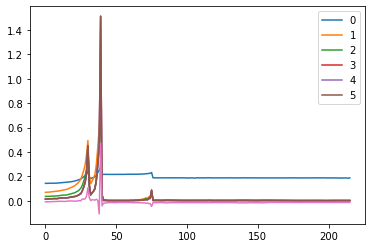

In [41]:
# mean went up and collapse until it finally starts training
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

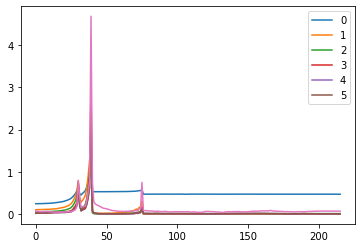

In [42]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

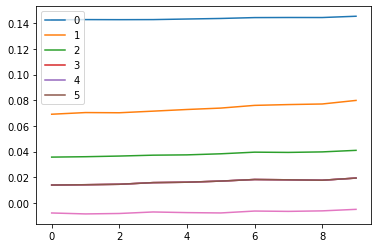

In [43]:
# less std, as layer increaes
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

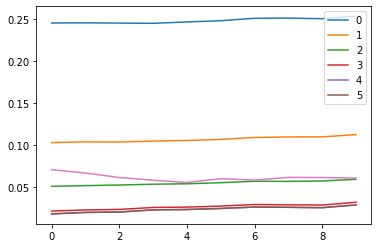

In [44]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

# Pytorch hooks
Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [45]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [46]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [47]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [48]:
# register forward hook in each layer
# module, input, output are fed by register_forward_hook automatically
for i,m in enumerate(model): 
    m.register_forward_hook(partial(append_stats, i))

In [49]:
run.fit(1, learn)

train : [1.81406296875, tensor(0.3767, device='cuda:0')]
valid : [0.64095673828125, tensor(0.7741, device='cuda:0')]


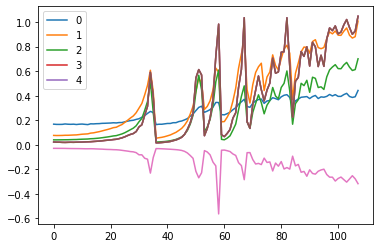

In [50]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

# Hook class

Fastai method

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [51]:
#export 

def children(m): return list(m.children())

class Hook():
    # m = l, append_stats = f
    def __init__(self, m, f): 
        # intialize, register it on some function
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    # remove automatically 
    def __del__(self): self.remove() 
        
def append_stats(hook, mod, inp, outp):
    # access to the hook, initalize hook stats
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [52]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [53]:
# m = l, append_stats = f
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [54]:
run.fit(1, learn)

train : [2.12689203125, tensor(0.2172, device='cuda:0')]
valid : [1.19316435546875, tensor(0.5973, device='cuda:0')]


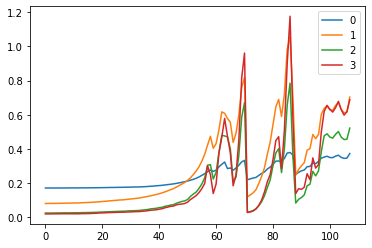

In [55]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

# A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices ([True,False,False,True,...])


The ``__iter__`` method is there to be able to do things like for x in ....

In [56]:
#export 
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self) #bool mask
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): # no need to print
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [57]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [58]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [59]:
t = ListContainer(range(10))
t[[1, 2]], t[[False]*8 + [True, False]]

([1, 2], [8])

In [60]:
[False]*8 + [True, False]

[False, False, False, False, False, False, False, False, True, False]

We can use it to write a ```Hooks``` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [61]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [62]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [63]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fba30cc7710>, <__main__.Hook object at 0x7fba30cc7da0>, <__main__.Hook object at 0x7fba30cc77f0>, <__main__.Hook object at 0x7fba30cc72e8>, <__main__.Hook object at 0x7fba30cc70b8>, <__main__.Hook object at 0x7fba30cc7ac8>, <__main__.Hook object at 0x7fba30cc78d0>]

In [64]:
hooks.remove()

In [65]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [66]:
x.mean(), x.std()

(tensor(0.0013, device='cuda:0'), tensor(1.0012, device='cuda:0'))

In [67]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1959, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3362, device='cuda:0', grad_fn=<StdBackward0>))

In [68]:
# initalize all with kaiming
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [69]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.3713, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8537, device='cuda:0', grad_fn=<StdBackward0>))

Having given an ```__enter__``` and ```__exit__``` method to our Hooks class, we can use it as a context manager. This makes sure that onces we are out of the with block, all the hooks have been removed and aren't there to pollute our memory.

train : [1.70382265625, tensor(0.4183, device='cuda:0')]
valid : [0.489383544921875, tensor(0.8388, device='cuda:0')]
train : [0.269666875, tensor(0.9171, device='cuda:0')]
valid : [0.15567027587890625, tensor(0.9535, device='cuda:0')]


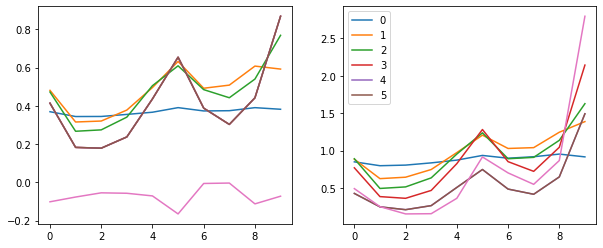

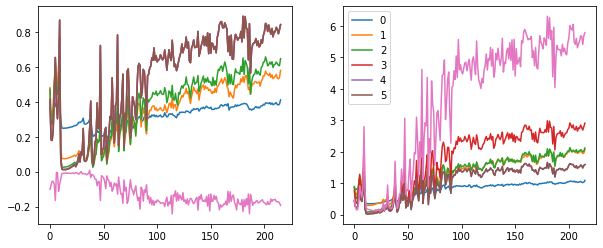

In [70]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        # mean and std of first 10
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

# Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [71]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, 0, 10))# histc isn't implemented on the gpu

In [72]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [73]:
# initalize all with kaiming
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [74]:
with Hooks(model, append_stats) as hooks: 
    run.fit(1, learn)

train : [1.39992265625, tensor(0.5333, device='cuda:0')]
valid : [0.32556865234375, tensor(0.8972, device='cuda:0')]


In [75]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

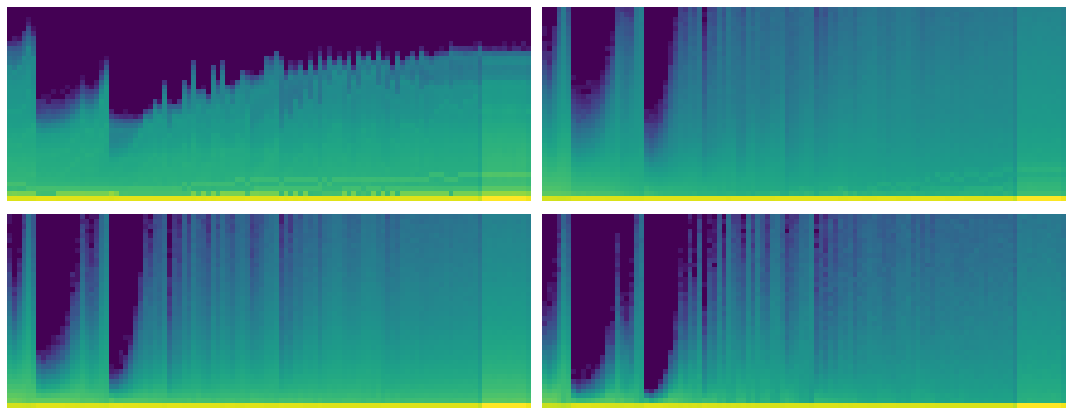

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
# how many axes
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

Grow collapse, grow collapse

yellow is most of the histogram is, care most about.

From the histograms, we can easily get more informations like the min or max of the activations

In [77]:
def get_min(h):
    # % of zeros or nearly zeros
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/ h1.sum(0)

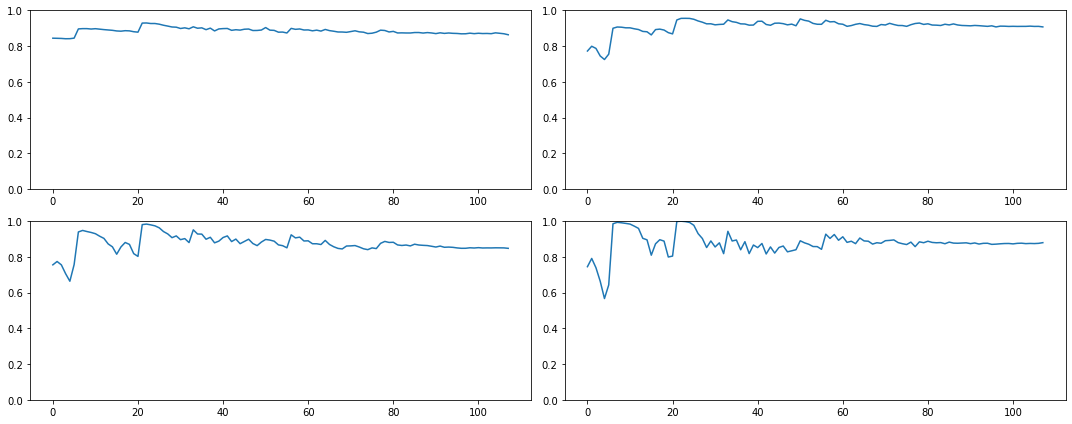

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

90% of activation in the fourth chart is wasted

# Generalized ReLU

In [86]:
#export

def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs)
    )

class GeneralRelu(nn.Module):
    # switch between leaky or relu, subtract and max value
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
            
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [87]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40, -7, 7)) # because of leaky relu

In [88]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train : [0.5103477734375, tensor(0.8373, device='cuda:0')]
valid : [0.14953348388671875, tensor(0.9545, device='cuda:0')]


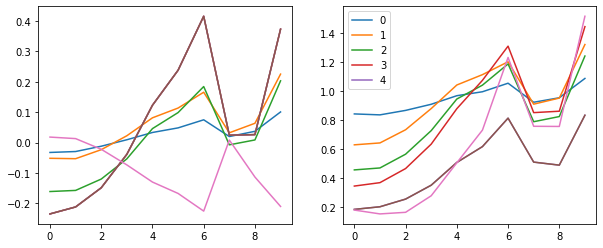

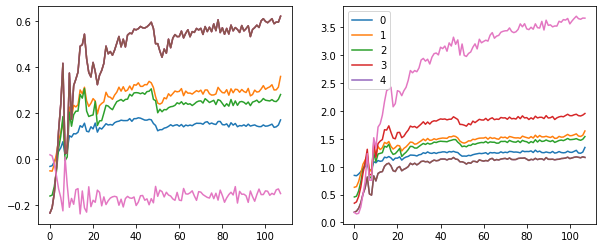

In [89]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5))
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

less flutation at the start

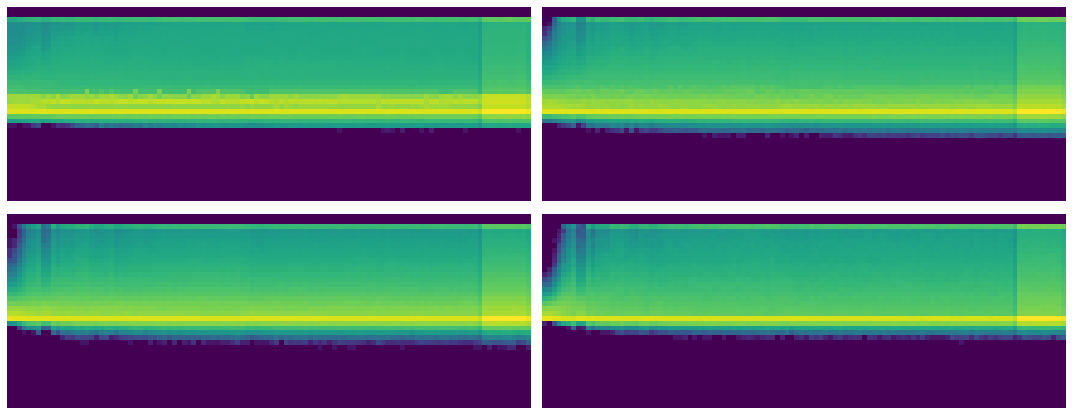

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

yellow is in the middle, less expand and die, saturated

In [92]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

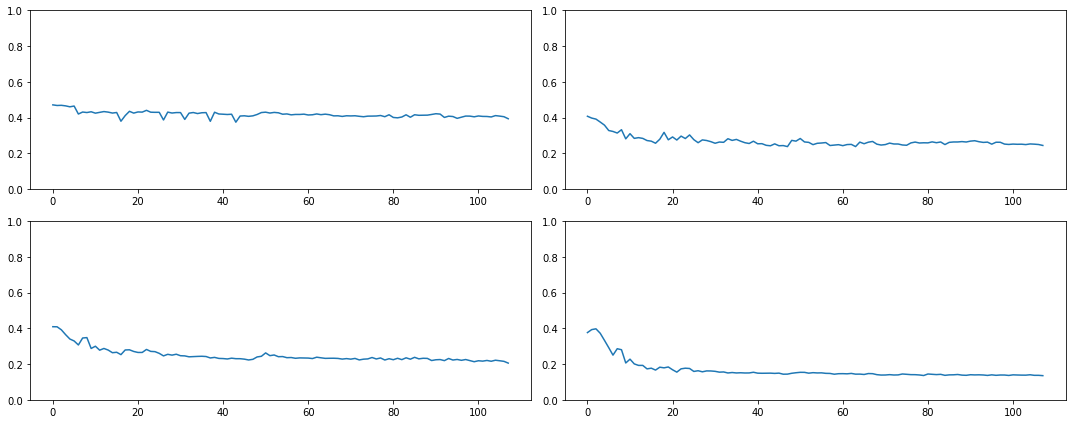

In [93]:
fig, axes = plt.subplots(2,2,figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

less than 20% activations are wasted

In [94]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [96]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [99]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [100]:
run.fit(8, learn)

train : [1.052981953125, tensor(0.6726, device='cuda:0')]
valid : [0.3500683349609375, tensor(0.8879, device='cuda:0')]
train : [0.31829919921875, tensor(0.9051, device='cuda:0')]
valid : [0.1879090087890625, tensor(0.9434, device='cuda:0')]
train : [0.330729609375, tensor(0.9032, device='cuda:0')]
valid : [0.5702248046875, tensor(0.8442, device='cuda:0')]
train : [0.1622609375, tensor(0.9494, device='cuda:0')]
valid : [0.10215056762695313, tensor(0.9684, device='cuda:0')]
train : [0.08393607421875, tensor(0.9741, device='cuda:0')]
valid : [0.07591296997070313, tensor(0.9782, device='cuda:0')]
train : [0.057259716796875, tensor(0.9823, device='cuda:0')]
valid : [0.06350787963867187, tensor(0.9811, device='cuda:0')]
train : [0.043346591796875, tensor(0.9865, device='cuda:0')]
valid : [0.0602012939453125, tensor(0.9833, device='cuda:0')]
train : [0.03588825927734375, tensor(0.9888, device='cuda:0')]
valid : [0.059303204345703124, tensor(0.9832, device='cuda:0')]


uniform is better?

In [101]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [102]:
run.fit(8, learn)

train : [1.09983515625, tensor(0.6442, device='cuda:0')]
valid : [0.390693212890625, tensor(0.8768, device='cuda:0')]
train : [0.313331328125, tensor(0.9022, device='cuda:0')]
valid : [0.73761416015625, tensor(0.7569, device='cuda:0')]
train : [0.2936513671875, tensor(0.9075, device='cuda:0')]
valid : [0.16982510986328125, tensor(0.9491, device='cuda:0')]
train : [0.130353662109375, tensor(0.9598, device='cuda:0')]
valid : [0.09112301025390625, tensor(0.9721, device='cuda:0')]
train : [0.084219541015625, tensor(0.9737, device='cuda:0')]
valid : [0.0739817138671875, tensor(0.9779, device='cuda:0')]
train : [0.0563651318359375, tensor(0.9821, device='cuda:0')]
valid : [0.06462872314453125, tensor(0.9812, device='cuda:0')]
train : [0.0411944873046875, tensor(0.9871, device='cuda:0')]
valid : [0.06285473022460937, tensor(0.9819, device='cuda:0')]
train : [0.0337982470703125, tensor(0.9899, device='cuda:0')]
valid : [0.05977811279296875, tensor(0.9825, device='cuda:0')]


# Export

In [103]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [104]:
#nb_auto_export()

<IPython.core.display.Javascript object>

In [105]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to exp/nb_06.py
